# Machine Learning for Climate Science Tutorial with Python

In this three-part tutorial series, we introduce some of the basic tools that are used in machine learning that may be useful for the tasks presented in _Challenge 3: Machine learning with climate and weather data_. 

__Note:__ this is a beginner's tutorial and aimed at students/researchers who are new to machine learning or are just getting started.

## Introduction
Broadly speaking, machine learning is a sub-field of artificial intelligence and statistics that deals with the automatic extraction of patterns (i.e. learning) from large amounts of data. We may categorize the types of learning as either __supervised__ or __unsupervised__ depending on whether the data we are given is labelled or not (there are also other types of learning such as _reinforcement learning_ that deals with learning from past mistakes, and *semi-supervised learning*, where only a subset of the data is labelled).

![Different types of machine learning](../images/ml-types.png)

Here, we'll only be concerned with supervised learning tasks, so our data will be *labelled*, by which we mean that it consists of a pair $(X_n, y_n)_{n=1}^N$ of __inputs__ $X_n$ and __labels__ $y_n$.

__Example:__ The inputs $X_n$ are images of chihuahuas and muffins, and the labels $y_n$ are the tags 'chihuahua' or 'muffin' (yes you read that right).

![chihuahuas vs muffins](../images/dogmuffin.png)

The primary task of supervised learning is to find a mapping $f : X \mapsto y$ that best represents the relationship between the inputs and labels, which, in ML lingo, is called **fitting the data**. Depending on whether the labels $y_n$ take values in a discrete or continuous set, the set of techniques used to fit the data are slightly different. The corresponding tasks also have different names: the former is called __classification__ and the latter is called **regression**.

In this tutorial, we will cover the basics of both classification and regression tasks, and will be organised as follows:
1. Classification with the Lorenz 63 system
2. Regression with the Lorenz 96 system
3. Handling real world datasets with `pandas`


## Part 1: Classification with the Lorenz 63 system

In the first part of this tutorial, we are going to introduce the basics of *statistical classification* using the famous Lorenz 63 model as a case study.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from datasets.lorenz import Lorenz63

The Lorenz 63 model (often shortened as L63) is given by the following three-dimensional set of nonlinear ODEs, introduced by the meteorologist Edward Lorenz in 1963 as a toy model for atmospheric convection:

\begin{align*}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{align*}

This model is famous for jump-starting the field of _chaos theory_ that has since become important in the physical sciences and especially in meteorology, demonstrating that it is practically impossible to forecast the weather far into the future.

This model has three parameters $(\sigma, \rho, \beta)$, which are usually set at $\sigma = 10, \rho = 28$ and $\beta = 8/3$, at which the system exhibits chaotic behaviour.

Now let's integrate and visualise the L63 system with the parameters set at the afforementioned values and see what we get...

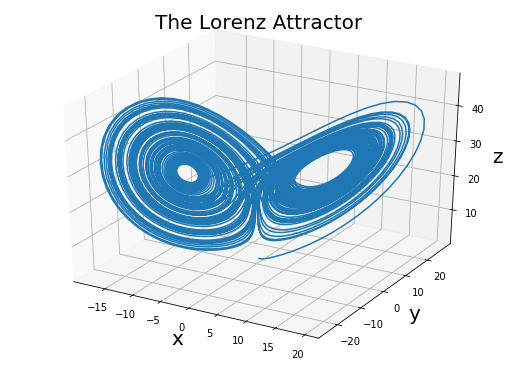

In [2]:
# Generate and plot the Lorenz attractor
tmax = 100
num_samples = 10000
dt = tmax/num_samples # 0.01
X0 = np.array([0, 1, 1.05]) # Initial condition

L63 = Lorenz63(tmax, X0, num_samples)
L63.plot()

The famous butterfly! This butterfly is called the *Lorenz attractor*.

Now let's say that given a point $X_0 = (x_0,y_0,z_0)$ on the Lorenz attractor, we want to predict where it will land after time $t=1$. Further, let's assume that we have absolutely no knowledge of the L63 equations and only have noisy measurements of its $(x,y,z)$-coordinates. Is this possible? Due to its chaotic nature, predicting the exact position is going to be difficult so we will simplify the problem a bit to make it more tractable:

#### Challenge: Given any point $X_0$ on the Lorenz attractor, determine which wing of the butterfly (left or right) it will end up in after time $t=1$.

Here, we define the right/left butterfly wing of the Lorenz attractor according to whether the x-component of $X$ is positive or negative respectively. You should realise that this is a _classification task_ since the labels 'left butterfly wing' and 'right butterfly wing' form a discrete set.

To proceed, let us first construct the function `which_wing` that takes in a sequence $X_{n} = (x_{n}, y_{n}, z_{n}), \, n = 1, \ldots, N$ of the L63 trajectory and generates a sequence of labels (0 or 1) depending on whether the future point $X_{n + \Delta n}$ lies on the left or right butterfly wing respectively, for fixed $\Delta n \in \mathbb{N}$.

In [3]:
def which_wing(X: np.array, lag: int) -> np.array:
    """ Returns array of 0s and 1s corresponding to whether a point on the attractor lands on the
        left or right wing respectively after n = lag timesteps
        Args:
            X: array of shape (num_samples, 3)
        
        Output: array of shape (num_samples - lag, )
    """
    x, y, z = X.transpose()
    return (x[lag:] > 0).astype(int)

We use this to generate the sequence of labels for our task.

In [4]:
tfinal = 1.
tsteps = int(tfinal/dt)

X = L63.trajectory
N = L63.num_samples

# Get sequence of 0/1s depending on whether each point X ends up on the left/right wing after time t=1
lag = tsteps
labels = which_wing(X,lag=lag)

Next, we visualise our task by color coding the points on the attractor: orange if the point ends up on the left butterfly wing after time $t=1$ and blue if it ends up on the right butterfly wing.

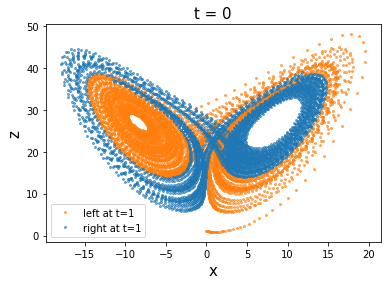

In [5]:
# Get indices corresponding to left/right wing after time t=1
left_indices = np.argwhere(labels == 0)
right_indices = np.argwhere(labels == 1)

# Extract subset of X that lies on the left/right wing after time t=1
eventually_left_X = X[left_indices].squeeze()
eventually_right_X = X[right_indices].squeeze()

# Plot
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
left_x, left_z = eventually_left_X[:,0], eventually_left_X[:,2]
right_x, right_z = eventually_right_X[:,0], eventually_right_X[:,2]
plt.plot(left_x, left_z, 'o', color='tab:orange', ms=2, alpha=0.6, label=f'left at t={int(tfinal)}')
plt.plot(right_x, right_z, 'o', color='tab:blue', ms=2, alpha=0.6, label=f'right at t={int(tfinal)}')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_title(f't = 0', fontsize=15)
ax.legend()
plt.show()

We can see from this that our objective is to learn a function $f$ that classifies points on the attractor into the orange or blue regions.

Below, we construct our labelled dataset $(X, y)$ where the inputs $X$ are noisy observations (here, noise is assumed to be i.i.d. Gaussian) of points on the Lorenz attractor and the labels $y$ are the corresponding 0/1 class.

In [6]:
# noise level
sigma = 0.1

# Dataset for our task
X = X[:N-lag] + sigma * np.random.randn(N-lag, 3)
y = labels

In the following sections, we will explore three common methods that can be used to fit the data $(X, y)$, namely, logistic regression, decision trees classification and neural network classification.

## 1. Logistic Regression

Despite the name logistic 'regression', this is really an algorithm used for classification. The main idea behind logistic regression is to model the probability of an input $X \in \mathbb{R}^m$ belonging to a given class $y$. For binary classification (i.e. there are only two classes $0$ or $1$), the probability of $X$ belonging to the class $1$ is computed using the so-called __sigmoid function__ $\sigma$ (see figure below), which squashes real numbers to take values between $0$ and $1$.

![Sigmoid graph](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F5152157%2F366ce717ad74dfe967a940d9a2161f9b%2Fmain-qimg-6b67bea3311c3429bfb34b6b1737fe0c.jpg?generation=1605711218576073&alt=media)

We assume a linear relationship between the inputs and the _logit_ (i.e. the raw output before applying the sigmoid function), giving us the predictive model

$$f(X; {\boldsymbol \beta}) = \sigma(\,\underbrace{\beta_0 + \beta_1 X[1] + \ldots + \beta_m X[m]}_{\text{logit}}\,) \in (0,1),$$

where $\boldsymbol{\beta} = (\beta_0, \beta_1, \ldots, \beta_m)$ are real-valued parameters. Notice that the outputs of this model are *continuous*, which seem to contradict the fact that this is a classification problem. Indeed, what we are doing here is performing _regression_ to solve a classification problem, hence the name logistic 'regression'!

The parameters $\boldsymbol{\beta}$ of the logistic regression model are determined by minimizing the **cross-entropy loss**:

$$L(y, f(X; {\boldsymbol \beta})) = - \left[y \log f(X; {\boldsymbol \beta}) + (1 - y) \log(1 - f(X; {\boldsymbol \beta}))\right],$$

which is a measure of discrepancy between two probability distributions (here we view the labels $0/1$ as the probability of being in class $1$). Note that plugging in the values of $y$ and $X$ from the dataset $(X_n, y_n)$ and taking the average, i.e. $\mathcal{L}(\boldsymbol{\beta}) = \frac1N \sum_{n} L(y_n, f(X_n; {\boldsymbol \beta}))$, this becomes a function of the model parameter $\boldsymbol{\beta}$ only. The minimiser ${\boldsymbol \beta}_*$ of $\mathcal{L}(\boldsymbol{\beta})$ can then be obtained through gradient-descent or some variant of gradient-descent.

__Note:__ While our discussion above has only been in the binary classification setting, all of this can be extended easily to the multi-class setting by replacing the sigmoid function with its multi-dimensional counterpart, namely the **softmax function** (see [this wikipedia page](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) for more details).

To fit our data using logistic regression, we'll work with the `scikit-learn` library.

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

A good practice in machine learning is to split the dataset into a __training__ and __testing set__ as shown in the figure below.

![training-testing-set](https://docs.splunk.com/images/thumb/3/3b/TrainTest.png/550px-TrainTest.png)

The training set is used to fit the model (i.e. determine the model parameters) and the testing set is only used at the very end to evaluate the performance of the model that was fit on the training set. By evaluating on the testing set which is not seen during training, we get an unbiased assessment of the model performance. Usually, training sets are chosen to be much larger than the test sets such as an 80/20% split.

__Tip:__ It is also a good practice to take a small chunk (approx. 10%) out of the training set called the *validation set* which can be used to select the best model and model configurations (i.e. tuning the model hyperparameters) before doing a final, final evaluation on the test set.

In `scikit-learn`, splitting the dataset randomly into training and testing sets can be achieved easily using `train_test_split`:

In [8]:
# Split dataset into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, labels, test_size=0.2)

Next, we wish to fit the data.
Fitting the logistic regression model to the training data (i.e. determining the model parameters $\beta_0, \ldots, \beta_m$) is extremely easy in `scikit-learn`, by simply using the `fit` method as we show below.

In [9]:
# Set up logistic regression model
model_lr = LogisticRegression()

# Fit model to training data
model_lr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Likewise, predicting the outputs of the model in `scikit-learn` is also very easy by using the `predict` method. Below, we plot the predictions of the model on the test dataset against the true labels.

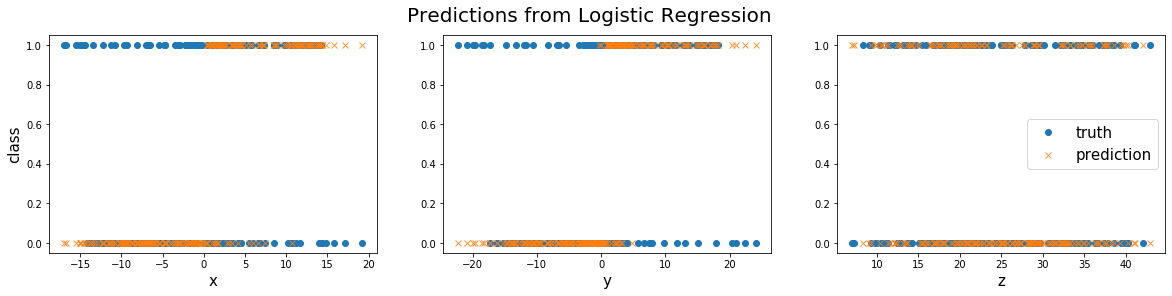

In [10]:
def plot_predictions(f, X, y, title):
    ypred = f(X)
    fig = plt.figure(figsize=(20, 4))
    coord = {0: 'x', 1: 'y', 2: 'z'}
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        plt.plot(X[:250,i], y[:250], 'o', label='truth')
        plt.plot(X[:250,i], ypred[:250], 'x', alpha=0.8, label='prediction')
        ax.set_xlabel(coord[i], fontsize=15)
        if i==0:
            ax.set_ylabel('class', fontsize=15)
    ax.legend(fontsize=15)
    plt.suptitle(title, fontsize=20)
    plt.show()

plot_predictions(model_lr.predict, test_X, test_y, 'Predictions from Logistic Regression')

We see that the predictions from the fit model are not perfect and misclassifies many points. To quantify exactly the percentage of points that the model classifies correctly, we use the `score` method:

In [11]:
# Evaluate model on the test set
accuracy_lr = model_lr.score(test_X, test_y)
print("Accuracy of logistic regression: {:.4f}".format(accuracy_lr))

Accuracy of logistic regression: 0.6621


The result isn't too bad (at least it's better than chance), but there is definitely room for improvement.

### Extending the feature vector

One way to improve the model performance is by extending or reducing the number of *features* used for prediction. *Feature* is just a fancy name for the components of the input vector used to predict the output labels. For example in our case, the features that were used for prediciton are the $x, y$ and $z$ components of the points in the Lorenz attractor.

However, we could have also considered a simpler model that makes predictions just based on the $x$ and $z$ components (reducing the features), or introduced a new feature $w = xy$ and made predictions based on the four-dimensional feature vector $(x, y, z, w)$ (extending the features).

Some reasons why *extending* the number of features can improve the model are:
- Important features may not be present in the inputs, leading to *underfitting*.
- It can introduce nonlinearity in the logit, which is otherwise linear in the inputs.

On the other hand, *reducing* the number of features can be beneficial when there are too many features present, thus leading to *overfitting* (also multicollinearity).

In our example, we choose to *extend* the number of features using the nonlinear map $\psi: \mathbb{R}^3 \rightarrow \mathbb{R}^6$ (called the *feature map*), given by

$$\psi(x, y, z) = (x, y, z, xy, yz, xz)^T,$$

thus augmenting the three components of L63 with extra quadratic interaction terms. We can do this in `scikit-learn` as follows.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
psi = poly.fit_transform

# Extend features in training and testing set
train_X_extended = psi(train_X)
test_X_extended = psi(test_X)

Next, we fit a logistic regression model on this new training set with extended features, i.e. we fit a model of the form

$$f(x,y,z) = \sigma( \boldsymbol{\beta}^T \psi(x,y,z) ) = \sigma(\beta_0 + \beta_1 x + \beta_2 y + \beta_3 z + \beta_4 xy + \beta_5 yz + \beta_6 xz)$$

In [13]:
# Set up new logistic regression model
model_lr_plus = LogisticRegression()

# Fit model on the extended training set
model_lr_plus.fit(train_X_extended, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

and evaluate this new model on the extended test set as before:

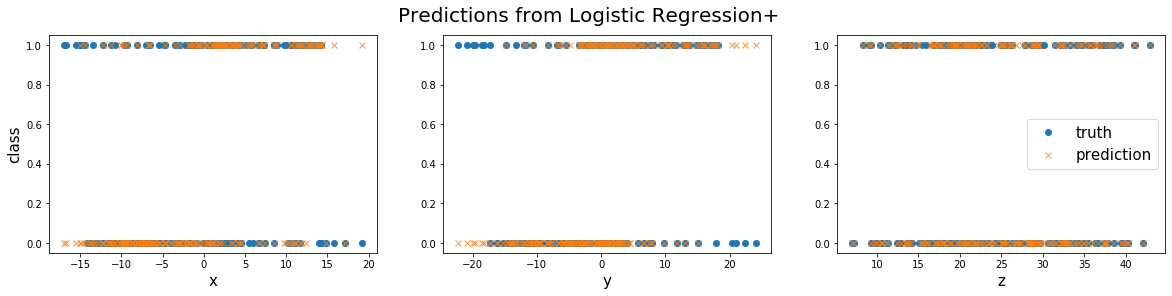

Accuracy of logistic regression with extra quadratic features: 0.7439


In [14]:
# Plot predictions and evaluate accuracy
accuracy_lr_ext = model_lr_plus.score(test_X_extended, test_y)
plot_predictions(model_lr_plus.predict, test_X_extended, test_y, 'Predictions from Logistic Regression+')
print("Accuracy of logistic regression with extra quadratic features: {:.4f}".format(accuracy_lr_ext))

We definitely see an improvement using this rather simple trick!

## 2. Decision Trees

The next popular method we are going to investigate is *decision tree classification*. A decision tree is basically a type of look-up table that allow us to make decisions. For example, let's say that there's a tree-hugging alien species that wants to know under what weather conditions it should go to the park without looking suspicious. By observing the humans in the city, it notices that there are three main attributes (features) that contribute to whether a person goes out to the park or not: precipitation, time and temperature. Based on the data they collected, they might form a decision tree like this:

![Decision tree](../images/decisiontree.png)

So for example, on a hot summer day at 2pm, it would decide to go out to the park based on this tree.

We'll omit the details on how to actually build a decision tree using the training data in order to save time, but you can check out [this excellent video](https://www.youtube.com/watch?v=7VeUPuFGJHk) if you want to know more.
In `scikit-learn`, building a decision tree can be done automatically using `DecisionTreeClassifier`, which we import below:

In [15]:
from sklearn.tree import DecisionTreeClassifier

In pretty much the same way as we have done with logistic regression, building a decision tree from the training data is extremely simple in `scikit-learn`, by using the `fit` method as follows:

In [16]:
# Set up a decision tree model
model_dt = DecisionTreeClassifier()

# fit training data
model_dt.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Let's visualise the tree that was just constructed and see how it classifies the points on the attractor.

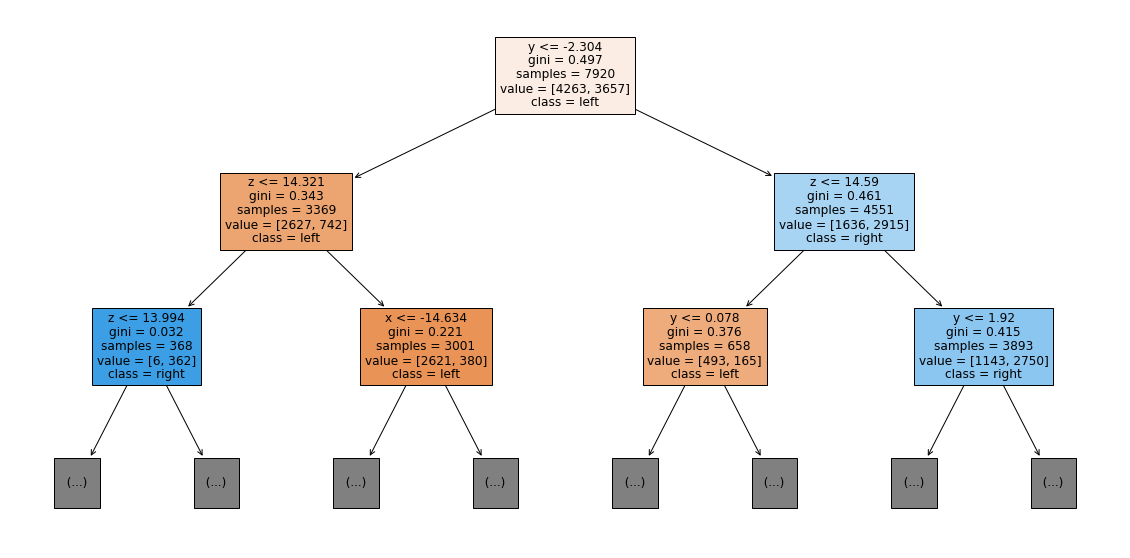

In [17]:
# Plot decision tree (up to depth 2)
fig = plt.figure(figsize = (20, 10))
sklearn.tree.plot_tree(model_dt,
                       max_depth = 2,
                       feature_names = ['x', 'y', 'z'],
                       class_names = ['left', 'right'],
                       filled = True)
plt.show()

Zooming into a single node of the tree, we see that it contains several information:

![decision tree node](../images/tree-node.png)

The first line gives us the condition for which to classify the inputs further down the tree (here, $z \leq 14.089$). If true, we follow the left arrow and if false, we follow the right arrow. Out of all the inputs in the training set, the number of data that end up on this node is displayed in the third line (samples $= 3379$), and the fourth line indicates how many of these training samples belong to classes $0$ or $1$. So if value $= [a, b]$, this means that out of all the training data that end up on this node, there are $a$ samples that belong to class $0$ and $b$ samples that belong to class $1$. Based on this, the last line tells us the most likely class an arbitrary input belongs to if it ended up on that node, which is determined by whether $a > b$ (class $=0$) or $a < b$ (class $=1$).
Finally, the *gini impurity*, indicated in the second line, measures how 'mixed' the training samples are at that node. This is computed as $g = \frac{2ab}{(a+b)^2}$ so it reaches a minimum (zero) if either $a$ or $b$ is zero. If `max_depth` is not specified during training, decision trees will be trained until all the leaves have zero impurity.

Now that we understand how decision tree works, let's go ahead and plot the predictions of the fitted model on the test data and compute the corresponding accuracy:

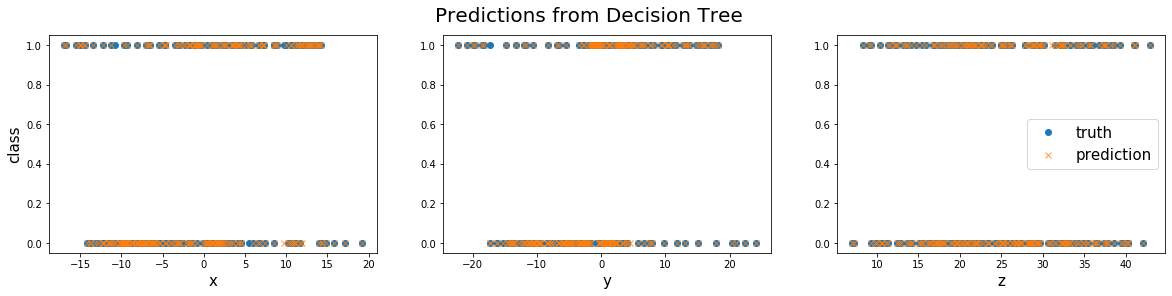

Accuracy of decision tree: 0.9545


In [18]:
# Compute accuracy of fitted tree on test data
accuracy_dt = model_dt.score(test_X, test_y)

# Plot predictions
plot_predictions(model_dt.predict, test_X, test_y, 'Predictions from Decision Tree')

# Print accuracy
print("Accuracy of decision tree: {:.4f}".format(accuracy_dt))

The result is incredible! We see why decision trees are such popular class of models: it is easy to setup, easy to understand (interpretable) and usually does a great job at classifying things. Next, let's see if we can do better by making decisions based on a whole bunch of decision trees instead of just one, giving us a model that is appropriately called *random forests*.

### Random forests

In *random forest classification*, the main idea is to make the decision process a bit more 'democratic' by taking votes from a whole bunch of trees (a *forest* so to say) instead of letting a single tree dictate the decision. This prevents the model from making overconfident decisions, which results in less overfitting and therefore better results.
For example, going back to the chihuahuas-and-muffins dataset from before, let's say that we are given an image of a muffin that really looks like a chihuahua (don't believe me?):

![muffin that looks like a chihuahua](../images/chihuahuamuffin.png)

A single decision tree might misclassify this as a chihuahua, but a random forest might get it right with slightly more votes for 'muffin':

![how random forests vote](../images/chihuahua-muffin-vote.png)

To construct the ensemble of trees in a random forest, we use a technique called *bagging*, which generates $m$ random training datasets by sampling (with replacement) from the original training set $m$ times. These new training datasets are then used to generate the trees in the forest.

Again, this can be done automatically in `scikit-learn` using `RandomForestClassifier`, which we import below.

In [19]:
from sklearn.ensemble import RandomForestClassifier

Next, we fit the model on the training data as before. Here, we restrict the depth of each tree to a maximum of 15 levels in order to save computation.

In [20]:
# Set up random forest model with a maximum depth of 15
model_rf = RandomForestClassifier(max_depth=15)

# Fit random forest on the training data
model_rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Below we visualise four trees in the forest that were generated and fitted on the training data. They all look slightly different.

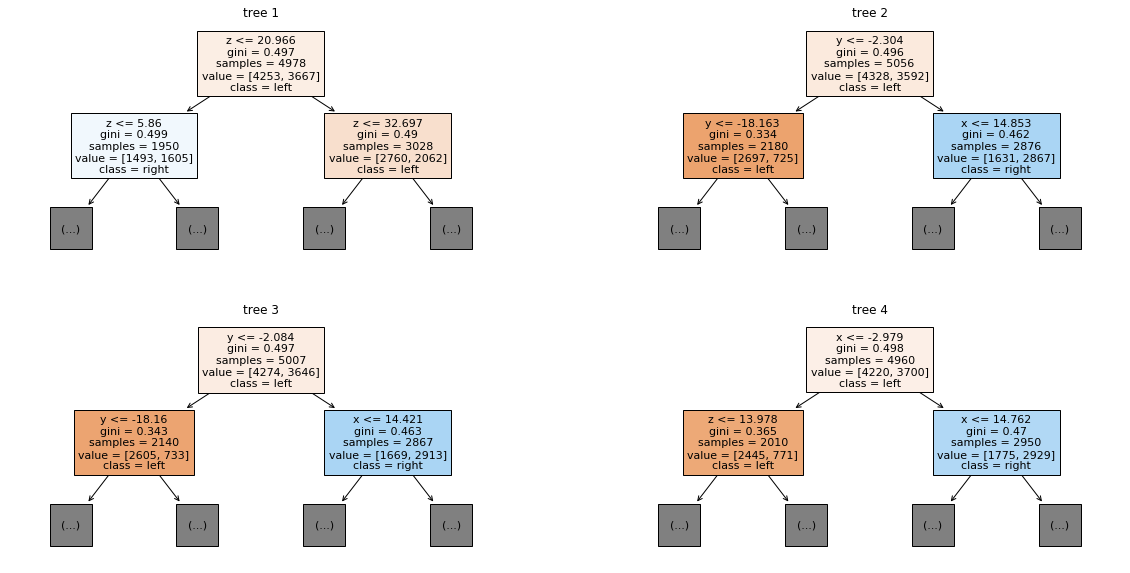

In [21]:
fig = plt.figure(figsize = (20, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    sklearn.tree.plot_tree(model_rf.estimators_[i],
                           max_depth = 1,
                           feature_names = ['x', 'y', 'z'],
                           class_names = ['left', 'right'],
                           filled = True)
    ax.set_title(f'tree {i+1}', fontsize=12)
plt.show()

Now let's see how the fitted random forest model performs on the test data.

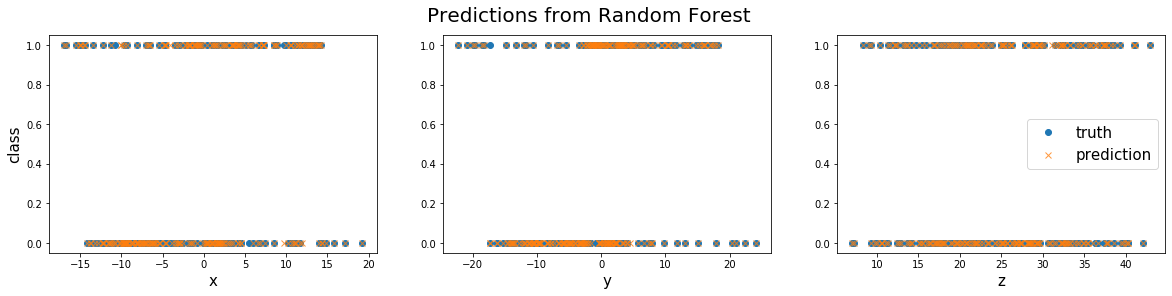

Accuracy of random forest: 0.9601


In [22]:
plot_predictions(model_rf.predict, test_X, test_y, 'Predictions from Random Forest')
accuracy_rf = model_rf.score(test_X, test_y)
print("Accuracy of random forest: {:.4f}".format(accuracy_rf))

Again, we see that this does a very good job at classifying the points on the attractor, but we don't see a huge improvement over decision trees (it might even be slightly worse depending on the run). This really depends on the problem at hand and we may or may not see a huge improvement by using random forests. In this case, a single decision tree already does a good job and extending to random forests didn't improve much.

## 3. Neural Networks

Finally, we look at a class of models called *neural networks*, which you have probably already heard about since they have become extremely popular in recent years. Neural networks are an extremely powerful and flexible class of models that can pretty much fit any data well given enough of them. Here, we'll only look at a certain class of neural networks called *multilayer perceptron (MLP)*, which has the following structure:

![multilayer perceptron](../images/neuralnet.png)

Each node in the figure, called *units*, can store a real number and is stacked into several *layers* that is of one of three types: input, hidden or output. Two nodes $(a, b)$ are connected by an arrow if the value at $b$ depends on the value at $a$. More hidden layers means going deeper. Remark on fully-connected/dense.

To make predictions with neural networks, we get an output $o$ by passing the input $X$ through the input layer, hidden layers and output layer as follows:

\begin{align*}
(\text{input layer}) \qquad & \quad x_i = flatten(X)_i \\ \\
(\text{hidden layers}) \qquad
&
\begin{cases}
h_i^{(1)} = \phi \left(\sum_j w_{ij}^{(1)} x_j + b_i^{(1)}\right) \\
h_i^{(2)} = \phi \left(\sum_j w_{ij}^{(2)} h_j^{(1)} + b_i^{(2)}\right) \\
\vdots \\
h_i^{(L)} = \phi \left(\sum_j w_{ij}^{(L)} h_j^{(L-1)} + b_i^{(L)}\right)
\end{cases}
\\ \\
(\text{output layer}) \qquad
&\quad o_i = \sum_j w_{ij}^{out} h_j^{(L)} + b_i^{out}
\end{align*}

The function $\phi : \mathbb{R} \rightarrow \mathbb{R}$ that is applied in the hidden layers is called an *activation function* and they can be pretty much any nonlinear, continuous function.
A popular choice for $\phi$ in recent years is the ReLU function, which looks like this:

![relu](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)

This might seem arbitrary at first but is justified mathematically by the *universal approximation theorem*, which can roughly be stated as follows:

**Theorem:** A multilayer perceptron with ReLU activation function can provide a piecewise linear approximation to *any* continuous function $f : \mathbb{R}^I \rightarrow \mathbb{R}^H$ arbitrarily closely given enough layers or units. This result can be also be extended to arbitrary activation funcitons under certain conditions.

In order to perform classification, we apply a sigmoid $\sigma$ in the last layer (or softmax in the multi-class case), giving us the predictive probability

$$\hat{y} = \sigma \left(\sum_j w^{out}_j h_j^{(L)} + b^{out} \right) \in (0,1).$$

The parameters of the model $(w, b)$ called *weights* and *biases* are then learnt by optimizing the cross-entropy loss $L(y, \hat{y})$, a process called *backpropagation*. We see that the number of parameters grow quickly as we increase the number of units and layers. It is not uncommon for neural networks to have millions or even billions of parameters! Overfit? No, double-descent. One of the great mysteries of neural networks.

We can therefore imagine MLP classification as just being a bigger, badder version of logistic regression with feature map $\psi: X \mapsto h^{(L)}$ that is *learnt* instead of being specified a priori.

In order to implement a multilayer perceptron in `python`, we will use the `keras` library, which offers a simple interface for builiding neural networks. Below, we import the necessary modules:

In [23]:
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization

### 3.1. Data pre-processing

Before sending an input data through the neural network, it is typically a good idea to apply re-scaling in order to increase its performance, since the network often faces difficulty when a variety of scales are present in the input features (see [this article](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) for more details on this).

Below, we look at the range of values that our input training data takes by using a box plot:

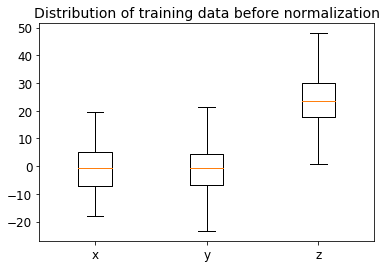

In [24]:
def box_plot(X: np.array, title: str):
    # X must have size (n_samples, 3)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.gca()
    plt.boxplot(X, labels=('x', 'y', 'z'), showfliers=False)
    ax.tick_params(axis='both', labelsize=12)
    plt.title(title, fontsize=14)
    plt.show()

box_plot(train_X, 'Distribution of training data before normalization')

We see that the inputs take a large range of values with the $z$ component taking much higher values than the $x$ and $y$ components. To fix this, we apply normalization to the training data $X$ by first computing its mean $\mu$ and variance $\sigma^2$, then applying the transformation $\hat{X} = (X - \mu)/\sigma$.

Of course you can apply this transformation by hand, but here we will use the `Normalization` class in `keras`' `preprocessing` module, which does this automatically for us. A nice thing about using `Normalization` to normalize the inputs is that its class instance can be treated as just another layer in the neural network that can be stacked with the other layers, as we shall see later.

To apply normalization, first, we use the `adapt` method to compute the mean and variance of the training data, which gets stored in the `mean` and `variance` attributes.

In [25]:
# Instantiate Normalization layer
Normalize = Normalization()

# Adapt to training data (i.e. compute its mean and variance)
Normalize.adapt(train_X)

# Print mean and variance
print(f'mean of training data: {Normalize.mean.numpy()}')
print(f'variance of training data: {Normalize.variance.numpy()}')

mean of training data: [-0.60577327 -0.5882626  23.942541  ]
variance of training data: [63.83774  80.213524 69.141594]


Next, we obtain a normalized training dataset $\hat{X}$ by passing the training set $X$ through the `Normalize` object, which applies the transformation $\hat{X} = (X - \mu)/\sigma$ using the values of mean and variance that it has stored earlier.

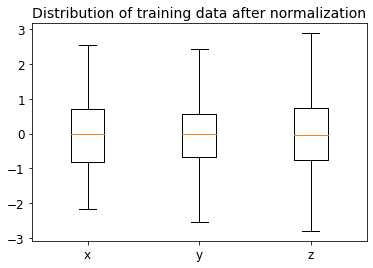

In [26]:
# Normalize training data
train_X_normalized = Normalize(train_X)

# Plot distribution of normalized data
box_plot(train_X_normalized.numpy(), 'Distribution of training data after normalization')

The data distribution looks much better now and we are ready to move on to the next step.

__Note:__ The test dataset will also be normalized using the mean and variance of the training dataset.

### 3.2. Setting up a neural network with keras

In order to set up a multilayer pereptron in `keras`, we use the `Sequential` class, which build neural networks intuitively by simply stacking up the neural network layers one-by-one:

In [27]:
model_nn = Sequential([
    
    # input layer
    Input(shape=(3,)),
    
    # normalization
    Normalize,
    
    # hidden layers
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    
    # output layer
    Dense(1, activation='sigmoid')

])

Let's break this down step-by-step. First of all, we can see intuitively even if you're not familiar with `keras` that we are just stacking up the neural network layers in order, as "input layer -> normalizing layer -> hidden layers -> output layer".

The input layer in `keras` is modelled using the `Input` object and here, we have chosen to specify the shape of our input, which is just a three-dimensional vector (if `shape` is not specified, this allows us to plug in tensors of any shapes without raising errors). We will assume here that the inputs are unnormalised, so the normalization step is going to be applied within the network in the following layer, using the `Normalize` layer that we created earlier and adapted to the training set.

The hidden and output layers will be modelled in `keras` using the `Dense` object, which takes in the number of units and activation function as arguments, and implements the operation $y = \phi(Wx + b)$, where $\phi$ is the activation function that is specified (if activation is unspecified, we just get an affine transformation). 
Thus, we see that our network consists of $5$ hidden layers with ReLU activation, each with $100$ units, and an output layer of a single unit with sigmoid activation.

Next, we specify the loss function and optimizer that we use to train our model, two essential ingredients aside from the network itself:

In [28]:
# Set loss function to be cross-entropy loss for binary classification
loss_fn = keras.losses.BinaryCrossentropy()

# Use the Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

and put all of these components together, using the `compile` method:

In [29]:
# Compile the model
model_nn.compile(loss=loss_fn,
                 optimizer=opt,
                 metrics=['accuracy'])

Note that we have specified `accuracy` as the metric with which we assess the model performance. Finally, we display the details of the network that we just put together using the `summary` method:

In [30]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1

### 3.3. Training and testing

Now we are ready to fit our neural network on the training data. As we have done with logistic regression and decision trees, fitting a neural network in `keras` is super simple if we use the `fit` method as we do below (warning: you will get an error if you forget to compile the model with a loss function and an optimizer in the previous step). We also have to specify the number of *training epochs*, which is how many times the optimization algorithm cycles over the entire training set. Here we choose `epochs=10`. Note also that we are using the *un-normalised* training set `train_X` here as we have included normalization as part of the neural network layers.

In [31]:
model_nn.fit(train_X, train_y, epochs=10)

Epoch 1/10
248/248 [==============================] - 1s 2ms/step - loss: 0.4625 - accuracy: 0.7894
Epoch 2/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2232 - accuracy: 0.8957
Epoch 3/10
248/248 [==============================] - 1s 4ms/step - loss: 0.1822 - accuracy: 0.9164
Epoch 4/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1566 - accuracy: 0.9264
Epoch 5/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1416 - accuracy: 0.9374
Epoch 6/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1299 - accuracy: 0.9439
Epoch 7/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1349 - accuracy: 0.9389
Epoch 8/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1214 - accuracy: 0.9462
Epoch 9/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1175 - accuracy: 0.9491
Epoch 10/10
248/248 [==============================] - 0s 2ms/step - loss: 0.1150 - accuracy: 0.9471

Now that we've fitted our model on the training set, we want to see how it performs on the test set so let's start by plotting the predictions.
Recall that the outputs of our neural network classifier is a *probability* between $0$ and $1$, however when predicting, we want the outputs to be either $0$ or $1$. For this, we will simply let the output be $0$ if the probability is below $0.5$ and $1$ otherwise. We do this using the `to_binary` class which we construct below and plot our predictions against the true labels as before.

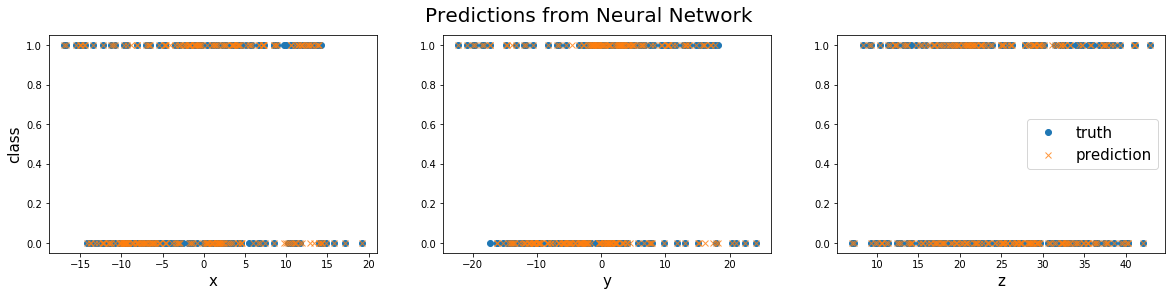

In [32]:
class to_binary():
    def __init__(self, model, cutoff=0.5):
        self.model = model
        self.cutoff = cutoff
    def predict(self, X):
        ypred = self.model(X)
        ypred_binary = np.array([0 if p < self.cutoff else 1 for p in ypred])
        return ypred_binary

model_nn_binary = to_binary(model_nn)
plot_predictions(model_nn_binary.predict, test_X, test_y, 'Predictions from Neural Network')

Looks pretty good! Now let's get a quantitative evaluation of the performance on the test set using the `evaluate` method as follows:

In [33]:
loss_nn, accuracy_nn = model_nn.evaluate(test_X, test_y)

62/62 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.9323


We see that the neural network does significantly better than logistic regression (both the vanilla version and the version with extended features), however it does not out-perform the decision tree/random forest classification. Hence, the winner of this task is decision tree/random forests!

__Tip:__ Experiment with different numbers of hidden layers, units, number of epochs, etc in the neural network and see how it affects the test accuracy. Also observe what happens when you remove the normalization layer from the network. You should see that the performance becomes slightly worse!